C:\Users\user\AppData\Local\Temp\ipykernel_33252\3246889455.py:251: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(211)


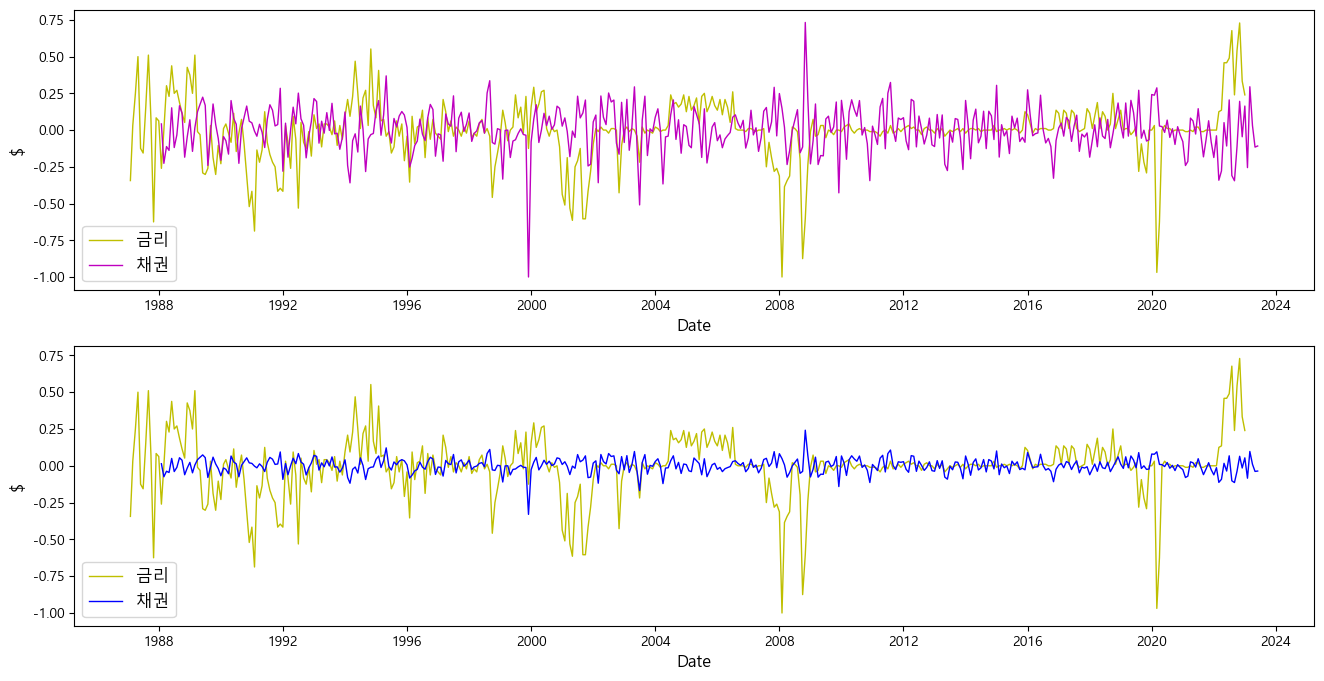

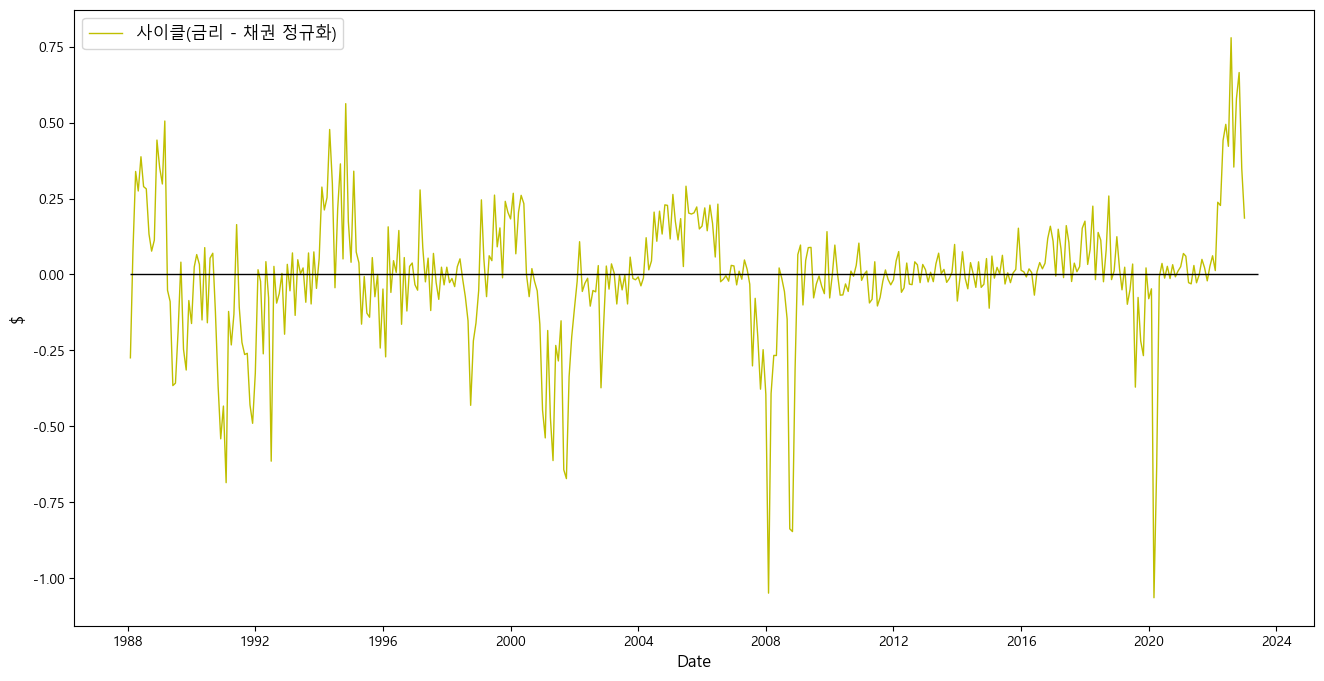

In [1]:
## 5가지 자산데이터(주식, 금, 부동산, 금리, 채권) 비율 그래프나옴
## 금리비율과 나머지 4개 자산데이터 평균으로 해서 비교하는 그래프나옴
## 사이클(금리 - 4개 지표평균) 그래프 나옴
# 금리비율 - 자산데이터 비율 뺀거에 사이클 다양하게 시도해보기


import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.stats.weightstats import ztest
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
from operator import itemgetter
from matplotlib.patches import Rectangle

from statsmodels.stats.weightstats import ztest
from statsmodels.tsa.seasonal import seasonal_decompose

import scipy.stats as stats

def print_head(df):
    print(df.head)

### CSV 파일 불러오기
stock_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/나스닥(1985~2023)_yfinance.csv')
gold_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/금(1950~2023)_캐글.csv')
interest_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/미국금리(1954.7~2023.5)_구글서치.csv')
house_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/케이스-쉴러_미국주택가격지수(1987.1~2023.4).csv')
bond_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/10년만기 미국채 선물 과거 데이터.csv')

#######--------------------------------------- 데이터 전처리 -------------------------------------------#######

### 데이터프레임 컬럼 이름 바꾸기
gold_df = gold_df.rename(columns={'Price USD per Oz':'Gold_Price'})
interest_df = interest_df.rename(columns={'FEDFUNDS':'Interest_Rate', "DATE":"Date"})
house_df = house_df.rename(columns={'SPCS10RSA':'House_Price', "DATE":"Date"})
bond_df = bond_df.rename(columns={'종가':'Bond_Close', "날짜":"Date"})

### 불러올 날짜 구간 설정(공통 1987-01-01 ~ 2023-07-01)
start = "1987-01-01" # 최소 1950-01-01
end = "2023-01-01" # 최대 2023-07-01
stock_df = stock_df[stock_df['Date'].between(start, end)]
gold_df = gold_df[gold_df['Date'].between(start, end)]
interest_df = interest_df[interest_df['Date'].between(start, end)]
house_df = house_df[house_df['Date'].between(start, end)]
bond_df = bond_df[bond_df['Date'].between(start,end)]

### 특정 칼럼(열) 삭제
stock_df = stock_df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)
bond_df = bond_df.drop(['시가', '고가', '저가', '변동 %'], axis = 1)


### 각 자산들을 지수화 하고 전월대비 현월 지수 차이 계산
# 금리(지수->지수)                                   # reset_index - 날짜 때문에 잘린 index를 0 부터 오름차순 재설정
interest_df = interest_df.reset_index(drop=True)    # 날짜 자르면서 index도 같이 잘림 -> index를 0으로 초기화 시키기
interest_df['Interest_Diff'] = 0
interest_df['Interest_Rate'] = interest_df['Interest_Rate'] / interest_df.loc[0, 'Interest_Rate'] * 100
for i in range (len(interest_df)-1):
    interest_df.loc[i+1, 'Interest_Diff'] = interest_df.loc[i+1, 'Interest_Rate'] - interest_df.loc[i, 'Interest_Rate']
interest_df = interest_df.drop(['Interest_Rate'], axis=1)
interest_df = interest_df.drop([0], axis=0)
# print(interest_df.head)

# 주가(지수->지수)
stock_df = stock_df.reset_index(drop=True)
stock_df['Stock_Diff'] = 0
stock_df['Close'] = stock_df['Close'] / stock_df.loc[0, 'Close'] * 100
for i in range (len(stock_df)-1):
    stock_df.loc[i+1, 'Stock_Diff'] = stock_df.loc[i+1, 'Close'] - stock_df.loc[i, 'Close']
stock_df = stock_df.drop(['Close'], axis=1)
stock_df = stock_df.drop([0], axis=0)
# print(stock_df.head)

# 금(가격->지수)
gold_df = gold_df.reset_index(drop=True)
gold_df['Gold_Diff'] = 0
for i in range (len(gold_df)-1):
    gold_df.loc[i+1, 'Gold_Price'] = (gold_df.loc[i+1, 'Gold_Price'] / gold_df.loc[0, 'Gold_Price']) * 100 # 지수 계산하기
gold_df.loc[0, 'Gold_Price'] = 100
for i in range (len(gold_df)-1):
    gold_df.loc[i+1, 'Gold_Diff'] = gold_df.loc[i+1, 'Gold_Price'] - gold_df.loc[i, 'Gold_Price'] # 전월 대비 현월 지수의 차이 계산하기
gold_df = gold_df.drop(['Gold_Price'], axis=1)
gold_df = gold_df.drop([0], axis=0)
# print(gold_df.head)

# 부동산(지수->지수)
house_df = house_df.reset_index(drop=True)
house_df['House_Diff'] = 0
house_df['House_Price'] = house_df['House_Price'] / house_df.loc[0, 'House_Price'] * 100
for i in range (len(house_df)-1):
    house_df.loc[i+1, 'House_Diff'] = house_df.loc[i+1, 'House_Price'] - house_df.loc[i, 'House_Price']
house_df = house_df.drop(['House_Price'], axis=1)
house_df = house_df.drop([0], axis=0)
# print(house_df.head)

# 채권(가격->지수)
bond_df = bond_df.reset_index(drop=True)
bond_df['Bond_Diff'] = 0
for i in range (len(bond_df)-1):
    bond_df.loc[i+1, 'Bond_Close'] = (bond_df.loc[i+1, 'Bond_Close'] / bond_df.loc[0, 'Bond_Close']) * 100
bond_df.loc[0, 'Bond_Close'] = 100
for i in range (len(bond_df)-1):
    bond_df.loc[i+1, 'Bond_Diff'] = bond_df.loc[i+1, 'Bond_Close'] - bond_df.loc[i, 'Bond_Close']
bond_df = bond_df.drop(['Bond_Close'], axis=1)
bond_df = bond_df.drop([0], axis=0)
# print(bond_df.head)


### 날짜 datatime 형식으로 전환하기
stock_df.loc[:,'Date'] = pd.to_datetime(stock_df.Date)
gold_df.loc[:,'Date'] = pd.to_datetime(gold_df.Date)
interest_df.loc[:,'Date'] = pd.to_datetime(interest_df.Date)
house_df.loc[:,'Date'] = pd.to_datetime(house_df.Date)
bond_df.loc[:,'Date'] = pd.to_datetime(bond_df.Date)


### index를 날짜로 변경하기
stock_df = stock_df.set_index('Date')
gold_df = gold_df.set_index('Date')
interest_df = interest_df.set_index('Date')
house_df = house_df.set_index('Date')
bond_df = bond_df.set_index('Date')

# ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ4가지 지표 가중평균 구하기, 4가지 정규화 지표 가중평균 구하기ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ 
### 4가지 지표 가중평균 구하기
weight_stock = 0.25 # 가중치
weight_gold = 0.25
weight_house = 0.25
weight_bond = 0.25

average_df = pd.concat([stock_df, gold_df, house_df, bond_df], axis=1)  # 4가지 데이터프레임 합치기

average_df['Average_Diff'] = average_df['Stock_Diff'] * weight_stock + average_df['Gold_Diff'] * weight_gold + average_df['House_Diff'] * weight_house + average_df['Bond_Diff'] * weight_bond  # 새로운 열 생성 후 가중평균 계산
# average_df['Average_Diff'] = average_df['Stock_Diff'] + average_df['Gold_Diff'] + average_df['House_Diff'] + average_df['Bond_Diff']  # 새로운 열 생성 후 평균구하기

average_df['Cycle_Curve'] = interest_df['Interest_Diff'] - average_df['Average_Diff'] # 새로운 열 생성 후 

cycle_df = pd.DataFrame(average_df['Cycle_Curve'])







# 4가지 지표 -1 ~ 1 사이 정규화(max abs)
stock_abs_df = stock_df / stock_df.abs().max()
gold_abs_df = gold_df / gold_df.abs().max()
interest_abs_df = interest_df / interest_df.abs().max()
house_abs_df = house_df / house_df.abs().max()
bond_abs_df = bond_df / bond_df.abs().max()

# ### 정규화(-1 ~ 1)
# scaler = MinMaxScaler(feature_range=(-1,1))

# stock_Diff_df = pd.DataFrame(data=stock_df.Stock_Diff)
# scaler.fit(stock_Diff_df)
# stock_scaled = scaler.transform(stock_Diff_df)
# stock_abs_df = pd.DataFrame(data=stock_scaled)

# gold_Diff_df = pd.DataFrame(data=gold_df.Gold_Diff)
# scaler.fit(gold_Diff_df)
# gold_scaled = scaler.transform(gold_Diff_df)
# gold_abs_df = pd.DataFrame(data=gold_scaled)

# interest_Diff_df = pd.DataFrame(data=interest_df.Interest_Diff)
# scaler.fit(interest_Diff_df)
# interest_scaled = scaler.transform(interest_Diff_df)
# interest_abs_df = pd.DataFrame(data=interest_scaled)

# house_Diff_df = pd.DataFrame(data=house_df.House_Diff)
# scaler.fit(house_Diff_df)
# house_scaled = scaler.transform(house_Diff_df)
# house_abs_df = pd.DataFrame(data=house_scaled)

# bond_Diff_df = pd.DataFrame(data=bond_df.Bond_Diff)
# scaler.fit(bond_Diff_df)
# bond_scaled = scaler.transform(bond_Diff_df)
# bond_abs_df = pd.DataFrame(data=bond_scaled)



# 4가지 정규화 지표 가중평균 구하기
# average_abs_df = pd.concat([stock_abs_df, gold_abs_df, house_abs_df, bond_abs_df], axis=1)
# average_abs_df['Average_Diff'] = average_abs_df['Stock_Diff']*0.33 + average_abs_df['Gold_Diff']*0.33 + average_abs_df['House_Diff']*0.33 + average_abs_df['Bond_Diff']*0.00

average_abs_df = pd.concat([bond_abs_df], axis=1)
average_abs_df['Average_Diff'] = average_abs_df['Bond_Diff']*0.33

average_abs_df = pd.DataFrame(average_abs_df['Average_Diff'])

average_abs_df['Cycle_Curve'] = interest_abs_df['Interest_Diff'] - average_abs_df['Average_Diff']

cycle_abs_df = pd.DataFrame(average_abs_df['Cycle_Curve'])


#######---------------------------------------- 시각화 ----------------------------------------------------######
def Setting():
    # 전역으로 그래프 사이즈 고정
    plt.rcParams["figure.figsize"] = (16,8)

    # 유니코드 깨짐현상 해결
    plt.rcParams['axes.unicode_minus'] = False
    
    # 나눔고딕 폰트 적용
    plt.rcParams["font.family"] = 'Malgun Gothic'
Setting()

# 데이터 주입
def Graph():
    # 그래프 타이틀
    plt.title('5-asset (' + start[2:4] + "." + start[5:7]+ "~" + end[2:4] + "." + end[5:7] + ")", fontsize=20) 
    
    plt.subplot(211)
    plt.plot(stock_df.index, stock_df.Stock_Diff, color='r', linewidth = 1)
    plt.plot(gold_df.index, gold_df.Gold_Diff, color='g', linewidth = 1)
    plt.plot(house_df.index, house_df.House_Diff, color='b', linewidth = 1)
    plt.plot(interest_df.index, interest_df.Interest_Diff, color='y', linewidth = 1)
    plt.plot(bond_df.index, bond_df.Bond_Diff, color='m', linewidth = 1)
    # plt.plot(average_df.index, average_df.Average_Diff, color = 'b', linewidth = 1)

    # x축, y축, 각 데이터의 이름 설정
    plt.ylabel('$', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend(['주식', '금', '부동산', '금리','채권'], fontsize=12, loc='best')


    plt.subplot(212)
    plt.plot(interest_df.index, interest_df.Interest_Diff, color='y', linewidth = 1)
    plt.plot(average_df.index, average_df.Average_Diff, color = 'b', linewidth = 1)
    plt.ylabel('$', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend(['금리','평균'], fontsize=12, loc='best')
    plt.show()


    plt.plot(cycle_df.index, cycle_df.Cycle_Curve, color='y', linewidth = 1)
    plt.hlines(0, cycle_df.index[0], cycle_df.index[len(cycle_df)-1], color='black', linewidth=3)
    plt.ylabel('$', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend(['사이클(금리 - 4지표평균)'], fontsize=12, loc='best')
    plt.show()
# Graph()

def Graph_Abs():
    # 그래프 타이틀
    plt.title('5-asset (' + start[2:4] + "." + start[5:7]+ "~" + end[2:4] + "." + end[5:7] + ")", fontsize=20) 
    
    plt.subplot(211)
    plt.plot(interest_abs_df.index, interest_abs_df.Interest_Diff, color='y', linewidth = 1)
    # plt.plot(stock_abs_df.index, stock_abs_df.Stock_Diff, color='r', linewidth = 1)
    # plt.plot(gold_abs_df.index, gold_abs_df.Gold_Diff, color='g', linewidth = 1)
    # plt.plot(house_abs_df.index, house_abs_df.House_Diff, color='b', linewidth = 1)
    plt.plot(bond_abs_df.index, bond_abs_df.Bond_Diff, color='m', linewidth =1)
    ## plt.plot(average_abs_df.index, average_abs_df.Average_Diff, color = 'b', linewidth = 1)

    # x축, y축, 각 데이터의 이름 설정
    plt.ylabel('$', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    # plt.legend(['금리', '주식', '금', '부동산','채권'], fontsize=12, loc='best')
    plt.legend(['금리', '채권'], fontsize=12, loc='best')

    plt.subplot(212)
    plt.plot(interest_abs_df.index, interest_abs_df.Interest_Diff, color='y', linewidth = 1)
    plt.plot(average_abs_df.index, average_abs_df.Average_Diff, color = 'b', linewidth = 1)
    plt.ylabel('$', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    # plt.legend(['금리','평균'], fontsize=12, loc='best')
    plt.legend(['금리','채권'], fontsize=12, loc='best')
    plt.show()


    plt.plot(cycle_abs_df.index, cycle_abs_df.Cycle_Curve, color='y', linewidth = 1)
    plt.hlines(0, cycle_abs_df.index[0], cycle_abs_df.index[len(cycle_abs_df)-1], color='black', linewidth=1)
    plt.ylabel('$', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    # plt.legend(['사이클(금리 - 4지표평균)'], fontsize=12, loc='best')
    plt.legend(['사이클(금리 - 채권 정규화)'], fontsize=12, loc='best')
    plt.show()
Graph_Abs()

def Corr():
    # 상관분석을 한번에 하기 위해 5가지 지표 합치기
    economic_df = pd.concat([stock_df, gold_df, house_df, bond_df], axis = 1)

    # 합친 데이터프레임의 열 이름 변환
    economic_df.columns = ['주가', '금', '부동산', '채권']

    # 상관관계 분석 함수 사용
    economic_cor = economic_df.corr()

    # heatmap 설정 후 그리기
    sns.set(style="white", font="Malgun Gothic", rc={"axes.unicode_minus":False})
    f, ax = plt.subplots(figsize=(5, 5)) # 표준화 된 지표 상관분석 표
    cmap = sns.diverging_palette(200, 10, as_cmap=True)
    sns.heatmap(economic_cor, cmap = cmap, center=0.0, square=True,
                linewidths=0.5, cbar_kws={"shrink": 0.75}, annot=True)

    # heatmap 타이틀과 x축, y축 이름 설정
    plt.title("5-asset (" + start[2:4] + "." + start[5:7]+ "~" + end[2:4] + "." + end[5:7] + ")", size=15)
    ax.set_xticklabels(list(economic_cor.columns), size=10, rotation=90)
    ax.set_yticklabels(list(economic_cor.columns), size=10, rotation=0)

    # 그래프, heatmap 동시 출력
    plt.show()
# Corr()
